# Prédiction du Churn Client
## Notebook d'exploration - En cours

TODO: nettoyer tout ça plus tard

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Charger les données clients
# (exécuter `python generate_sample_data.py` d'abord si le fichier n'existe pas)
df = pd.read_csv('../data/customer_data.csv')

print(f"Dimensions du dataset: {df.shape}")
df.head()

Dimensions du dataset: (5000, 10)


,customer_id,recency_days,frequency,monetary_value,avg_order_value,days_since_signup,total_orders,support_tickets,age,churned
0,1,156,9,6800.38,759.81,596,9,0,18,1
1,2,66,14,792.94,94.69,393,7,0,29,0
2,3,97,3,1005.08,285.39,367,3,0,37,1
3,4,1,11,2844.91,404.44,367,6,0,38,0
4,5,19,5,1749.75,136.75,1084,12,2,18,1


## Analyse Exploratoire (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        5000 non-null   int64  
 1   recency_days       5000 non-null   int64  
 2   frequency          5000 non-null   int64  
 3   monetary_value     5000 non-null   float64
 4   avg_order_value    5000 non-null   float64
 5   days_since_signup  5000 non-null   int64  
 6   total_orders       5000 non-null   int64  
 7   support_tickets    5000 non-null   int64  
 8   age                5000 non-null   int64  
 9   churned            5000 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 390.8 KB


In [4]:
df.describe()

,customer_id,recency_days,frequency,monetary_value,avg_order_value,days_since_signup,total_orders,support_tickets,age,churned
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,69.058800,10.728400,1573.179302,244.907142,500.76300,7.562400,0.972200,39.995400,0.490400
std,1443.520003,67.941087,5.180811,1240.720473,227.646047,304.74602,5.894731,1.329128,13.784679,0.499958
min,1.000000,0.000000,0.000000,50.000000,10.000000,30.00000,1.000000,0.000000,18.000000,0.000000
25%,1250.750000,19.000000,7.000000,707.985000,94.705000,274.00000,3.000000,0.000000,30.000000,0.000000
50%,2500.500000,48.000000,10.000000,1272.055000,174.840000,438.00000,6.000000,1.000000,40.000000,0.000000
75%,3750.250000,98.000000,14.000000,2077.460000,315.130000,664.25000,10.000000,1.000000,49.000000,1.000000
max,5000.000000,365.000000,31.000000,11958.630000,3034.510000,1500.00000,44.000000,11.000000,75.000000,1.000000


In [5]:
# vérifier la distribution de la cible
df['churned'].value_counts()

churned
0    2548
1    2452
Name: count, dtype: int64

In [6]:
df['churned'].value_counts(normalize=True)

churned
0    0.5096
1    0.4904
Name: proportion, dtype: float64

In [7]:
# vérifier les valeurs manquantes
df.isnull().sum()

customer_id          0
recency_days         0
frequency            0
monetary_value       0
avg_order_value      0
days_since_signup    0
total_orders         0
support_tickets      0
age                  0
churned              0
dtype: int64

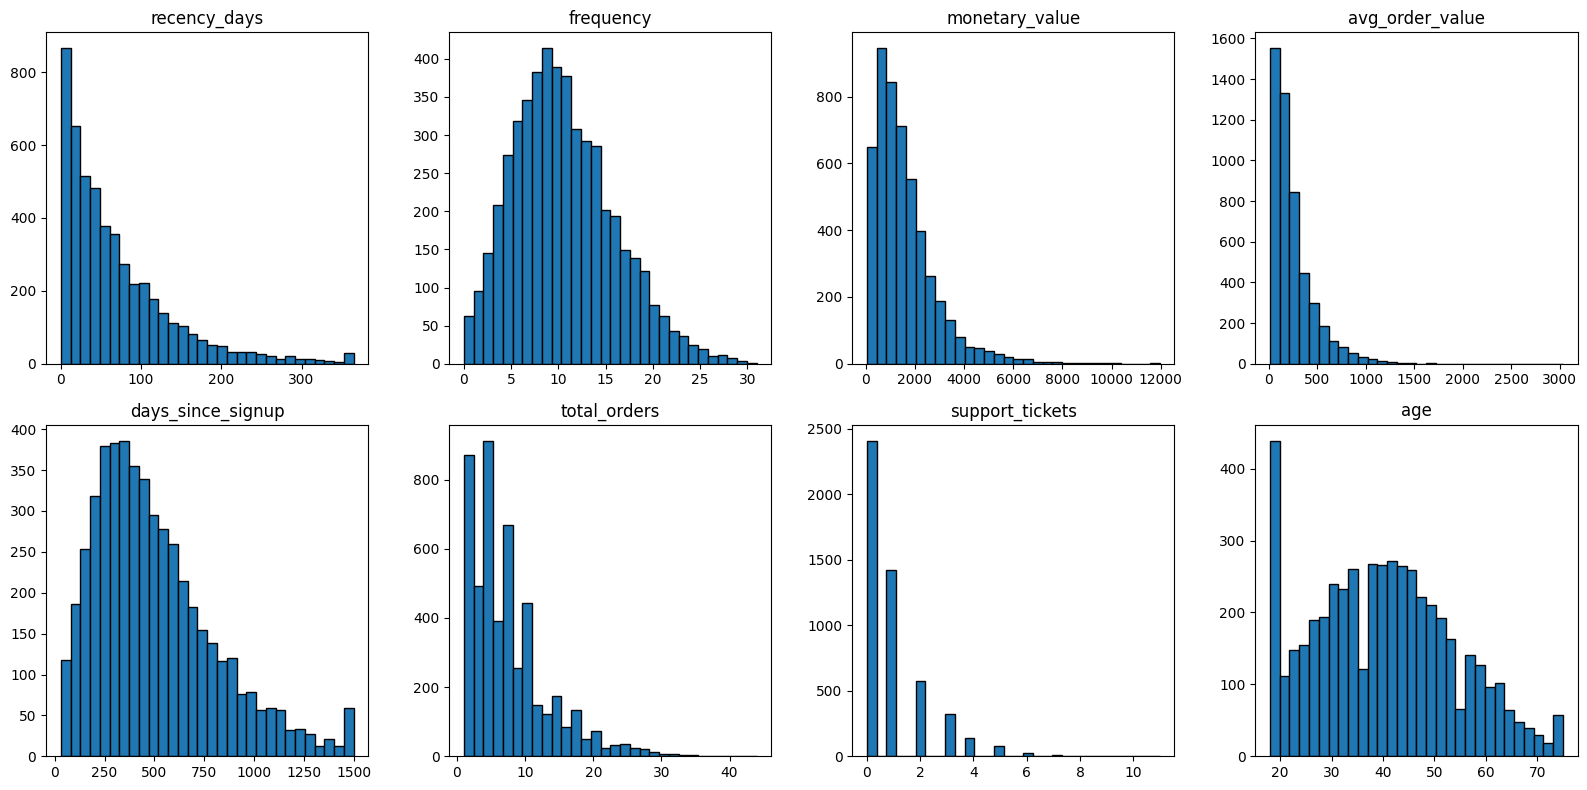

In [8]:
# graphiques de distribution
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df.columns[1:-1]):  # ignorer customer_id et churned
    axes[i].hist(df[col], bins=30, edgecolor='black')
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

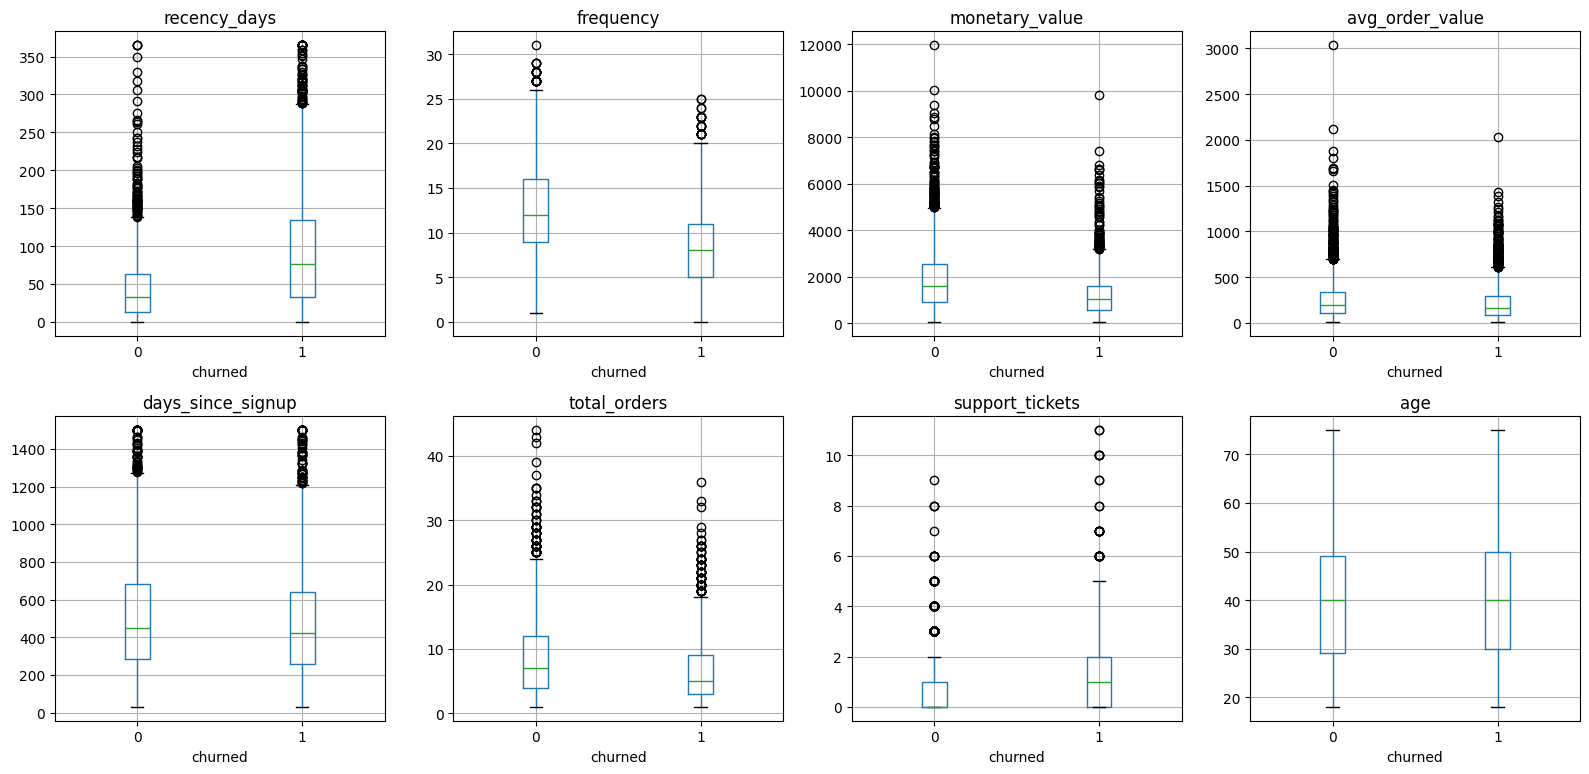

In [9]:
# boxplots par statut de churn
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df.columns[1:-1]):
    df.boxplot(column=col, by='churned', ax=axes[i])
    axes[i].set_title(col)

plt.suptitle('')
plt.tight_layout()
plt.show()

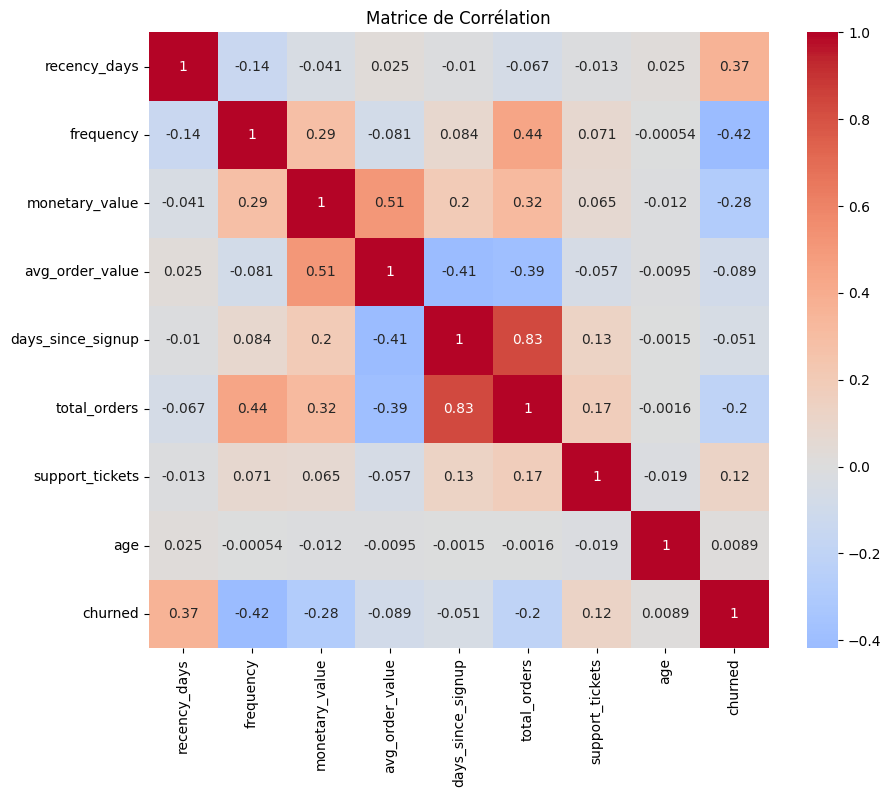

In [10]:
# matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('customer_id', axis=1).corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation')
plt.show()

## Feature Engineering

Créons quelques nouvelles features

In [11]:
# créer de nouvelles features
df['recency_frequency_ratio'] = df['recency_days'] / (df['frequency'] + 1)
df['monetary_per_order'] = df['monetary_value'] / (df['total_orders'] + 1)
df['order_frequency'] = df['total_orders'] / (df['days_since_signup'] + 1)
df['support_per_order'] = df['support_tickets'] / (df['total_orders'] + 1)

# Score RFM - binning manuel
df['r_score'] = pd.qcut(df['recency_days'], q=5, labels=[5, 4, 3, 2, 1]).astype(int)
df['f_score'] = pd.qcut(df['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)
df['m_score'] = pd.qcut(df['monetary_value'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)
df['rfm_score'] = df['r_score'] + df['f_score'] + df['m_score']

df.head()

,customer_id,recency_days,frequency,monetary_value,avg_order_value,days_since_signup,total_orders,support_tickets,age,churned,recency_frequency_ratio,monetary_per_order,order_frequency,support_per_order,r_score,f_score,m_score,rfm_score
0,1,156,9,6800.38,759.81,596,9,0,18,1,15.600000,680.038000,0.015075,0.000000,1,2,5,8
1,2,66,14,792.94,94.69,393,7,0,29,0,4.400000,99.117500,0.017766,0.000000,2,4,2,8
2,3,97,3,1005.08,285.39,367,3,0,37,1,24.250000,251.270000,0.008152,0.000000,2,1,2,5
3,4,1,11,2844.91,404.44,367,6,0,38,0,0.083333,406.415714,0.016304,0.000000,5,3,5,13
4,5,19,5,1749.75,136.75,1084,12,2,18,1,3.166667,134.596154,0.011060,0.153846,4,1,4,9


In [12]:
df.shape

(5000, 18)

## Préparation des données pour la modélisation

In [13]:
# features à utiliser
feature_cols = [
    'recency_days', 'frequency', 'monetary_value', 'avg_order_value',
    'days_since_signup', 'total_orders', 'support_tickets', 'age',
    'recency_frequency_ratio', 'monetary_per_order', 'order_frequency',
    'support_per_order', 'rfm_score'
]

X = df[feature_cols]
y = df['churned']

print(f"Dimensions des features: {X.shape}")
print(f"Dimensions de la cible: {y.shape}")

Dimensions des features: (5000, 13)
Dimensions de la cible: (5000,)


In [14]:
# séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ensemble d'entraînement: {X_train.shape[0]} échantillons")
print(f"Ensemble de test: {X_test.shape[0]} échantillons")

Ensemble d'entraînement: 4000 échantillons
Ensemble de test: 1000 échantillons


In [15]:
# normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modèle 1: Régression Logistique

In [16]:
# régression logistique
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Résultats Régression Logistique:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1: {f1_score(y_test, y_pred_lr):.4f}")

Résultats Régression Logistique:
Accuracy: 0.8050
Precision: 0.8067
Recall: 0.7918
F1: 0.7992


In [17]:
# validation croisée
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

CV Accuracy: 0.7815 (+/- 0.0137)


## Modèle 2: Random Forest

In [18]:
# random forest - essayer différents paramètres
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest (n_estimators=100) Résultats:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1: {f1_score(y_test, y_pred_rf):.4f}")

Random Forest (n_estimators=100) Résultats:
Accuracy: 0.7770
Precision: 0.7730
Recall: 0.7714
F1: 0.7722


In [19]:
# hmm essayons avec plus d'arbres
rf2 = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf2.fit(X_train, y_train)

y_pred_rf2 = rf2.predict(X_test)

print("Random Forest (n_estimators=200, max_depth=10) Résultats:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf2):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf2):.4f}")
print(f"F1: {f1_score(y_test, y_pred_rf2):.4f}")

Random Forest (n_estimators=200, max_depth=10) Résultats:
Accuracy: 0.7840
Precision: 0.7796
Recall: 0.7796
F1: 0.7796


In [20]:
# essayons une autre configuration
rf3 = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_split=10, random_state=42, n_jobs=-1)
rf3.fit(X_train, y_train)

y_pred_rf3 = rf3.predict(X_test)

print("Random Forest (n_estimators=150, max_depth=15, min_samples_split=10) Résultats:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf3):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf3):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf3):.4f}")
print(f"F1: {f1_score(y_test, y_pred_rf3):.4f}")

Random Forest (n_estimators=150, max_depth=15, min_samples_split=10) Résultats:
Accuracy: 0.7860
Precision: 0.7816
Recall: 0.7816
F1: 0.7816


In [21]:
# validation croisée sur le meilleur RF jusqu'ici
cv_scores_rf = cross_val_score(rf2, X_train, y_train, cv=5, scoring='accuracy')
print(f"RF CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std()*2:.4f})")

RF CV Accuracy: 0.7737 (+/- 0.0104)


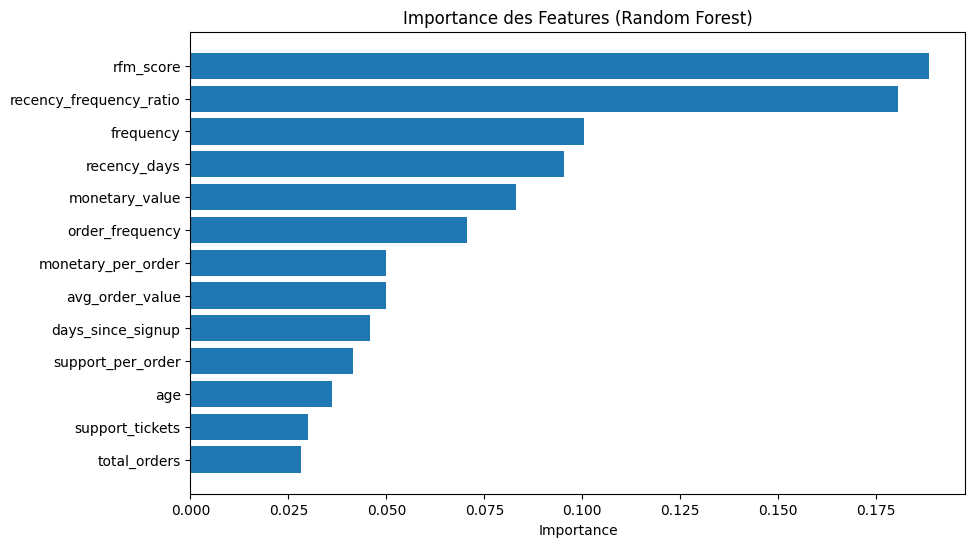

In [22]:
# importance des features
feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Importance')
plt.title('Importance des Features (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

## Modèle 3: Gradient Boosting

In [23]:
# gradient boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Résultats Gradient Boosting:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1: {f1_score(y_test, y_pred_gb):.4f}")

Résultats Gradient Boosting:
Accuracy: 0.7970
Precision: 0.7923
Recall: 0.7939
F1: 0.7931


In [24]:
# essayons un learning rate différent
gb2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gb2.fit(X_train, y_train)

y_pred_gb2 = gb2.predict(X_test)

print("Gradient Boosting (lr=0.05, n=200) Résultats:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb2):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb2):.4f}")
print(f"F1: {f1_score(y_test, y_pred_gb2):.4f}")

Gradient Boosting (lr=0.05, n=200) Résultats:
Accuracy: 0.7850
Precision: 0.7847
Recall: 0.7735
F1: 0.7790


## Optimisation des hyperparamètres avec GridSearch

Essayons une grid search sur RF

In [25]:
# grid search - ça prend du temps
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Meilleurs paramètres: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Meilleur score: 0.7705


In [26]:
# évaluer le meilleur modèle
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Résultats Meilleur Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1: {f1_score(y_test, y_pred_best):.4f}")

Résultats Meilleur Random Forest:
Accuracy: 0.7810
Precision: 0.7771
Recall: 0.7755
F1: 0.7763


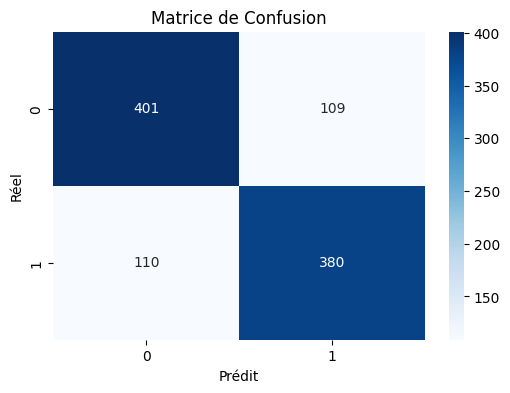

In [27]:
# matrice de confusion
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

In [28]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       510
           1       0.78      0.78      0.78       490

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



## Résumé

| Modèle | Accuracy | Precision | Recall | F1 |
|--------|----------|-----------|--------|----|
| Régression Logistique | ? | ? | ? | ? |
| Random Forest (100) | ? | ? | ? | ? |
| Random Forest (200, depth=10) | ? | ? | ? | ? |
| Gradient Boosting | ? | ? | ? | ? |
| Meilleur RF (grid search) | ? | ? | ? | ? |

TODO: remplir le tableau manuellement...

Le meilleur modèle semble être RF avec les paramètres de grid search. Il faut sauvegarder ce modèle et le déployer quelque part.

In [29]:
# sauvegarder le modèle? je sais pas où
# import pickle
# with open('model.pkl', 'wb') as f:
#     pickle.dump(best_rf, f)

# attends c'était lequel le meilleur déjà? laisse moi remonter...

In [30]:
# en fait laisse moi essayer encore un truc - et si je retirais des features?
# peut-être que je suis en overfitting

# garder seulement les top features
top_features = feat_imp.head(8)['feature'].tolist()
print(f"Top features: {top_features}")

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

rf_top = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_top.fit(X_train_top, y_train)

y_pred_top = rf_top.predict(X_test_top)

print("\nRF avec top 8 features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_top):.4f}")
print(f"F1: {f1_score(y_test, y_pred_top):.4f}")

Top features: ['rfm_score', 'recency_frequency_ratio', 'frequency', 'recency_days', 'monetary_value', 'order_frequency', 'monetary_per_order', 'avg_order_value']

RF avec top 8 features:
Accuracy: 0.7700
F1: 0.7653


In [31]:
# ok j'abandonne d'essayer de suivre toutes ces expériences
# c'était lequel le meilleur? je crois que c'était celui de grid search?
# ou alors gb2?

# TODO: utiliser mlflow ou autre chose pour tracker tout ça...

---

## Notes pour moi-même

- Meilleur modèle: probablement RF de grid search?
- Besoin de trouver comment mieux tracker les expériences
- Est-ce que je dois sauvegarder le scaler aussi?
- Comment je déploie ça?
- Marie a dit quelque chose sur MLflow?
- Il faut aussi exécuter ça tous les jours pour les nouveaux clients - manuellement? cron job?

**Problèmes avec ce notebook:**
1. Je ne me souviens plus quel modèle était le meilleur
2. Les métriques sont éparpillées partout
3. Pas de versioning des modèles
4. Impossible de reproduire exactement les résultats
5. Pas d'automatisation
6. Tout est hardcodé